In [2]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain.prompts import ChatPromptTemplate, BasePromptTemplate, PromptTemplate
from langchain_core.output_parsers import StrOutputParser, JsonOutputParser
from langchain.output_parsers.xml import XMLOutputParser
from pydantic import BaseModel, Field

## Text Loaders and Splitters
from langchain.document_loaders import PyPDFLoader, WebBaseLoader, TextLoader, JSONLoader, UnstructuredXMLLoader, ArxivLoader, WikipediaLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter, CharacterTextSplitter, RecursiveJsonSplitter
from langchain_core.documents import Document
import bs4
import requests

## Embeddings
from langchain_openai import OpenAIEmbeddings
from langchain_huggingface import HuggingFaceEmbeddings
# from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
# import faiss
from langchain_community.vectorstores import FAISS, Chroma
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain import hub
# import pprintr
from langchain_core.runnables import RunnablePassthrough

from langchain.agents import tool
from langchain_community.tools import WikipediaQueryRun, YouTubeSearchTool
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain.tools import DuckDuckGoSearchRun


from langgraph.graph import StateGraph, END, MessagesState, START
from IPython.display import Image, display
import operator
from typing_extensions import TypedDict
from typing import Annotated, Sequence
# from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage

from langgraph.prebuilt import ToolNode


In [3]:
load_dotenv()

True

In [4]:
model = ChatOpenAI(model="gpt-4o", temperature=0.0, max_retries=3)
model.invoke("What is the GPD of the USA?")

AIMessage(content="As of the latest data available in 2023, the Gross Domestic Product (GDP) of the United States is approximately $25 trillion. However, GDP figures are subject to revisions and updates, so for the most current and precise information, it's best to refer to official sources such as the U.S. Bureau of Economic Analysis (BEA).", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 69, 'prompt_tokens': 16, 'total_tokens': 85, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-C0q8WyAnu208NtXPoF7CThL5f1Hsv', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--85e312fa-a056-4291-96b8-b86b1d90c04b-0', usage_metadata={'input_tokens': 16, 'output_tokens': 69, 'total_tok

## TOOL 1

In [5]:
key = os.getenv("TAVILY_API_KEY")
tavily_tool = TavilySearchResults(api_key=key)

/var/folders/6p/ddx1yx2j547512yh8wlgztw00000gn/T/ipykernel_18326/4280750209.py:2: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(api_key=key)


In [6]:
tools = [tavily_tool]

## Tool Node 1

In [7]:
tool_node = ToolNode(tools=tools)

In [8]:
model_with_tools = model.bind_tools(tools)

## Node 2

In [9]:
def call_model(state: MessagesState) -> MessagesState:
    messages = state["messages"]

    print("Messages before invoking model:", messages)
    response = model_with_tools.invoke(messages)

    print("Model response:", response)

    return {"messages": [response]}

In [10]:
def router(state: MessagesState) -> MessagesState:
    messages = state["messages"]
    print("Router messages:", messages)

    message = messages[-1]

    print("Last message:", message)
    print("Tool calls in last message:", message.tool_calls)

    if message.tool_calls:
        return "tools"
    return END

In [26]:
workflow = StateGraph(MessagesState)

In [27]:
workflow.add_node("supervisor", call_model)
workflow.add_node("mytools", tool_node)

workflow.add_conditional_edges("supervisor", router, {
    "tools": "mytools",
    END: END
})

workflow.add_edge(START, "supervisor")
workflow.add_edge("mytools", "supervisor")

In [28]:
app = workflow.compile()

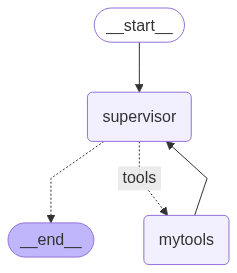

In [29]:
app = workflow.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [30]:
for output in app.stream({"messages":["what is a weather in new delhi?"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")

Messages before invoking model: [HumanMessage(content='what is a weather in new delhi?', additional_kwargs={}, response_metadata={}, id='3b4863f9-c160-42e7-8efc-17010f60cbab')]
Model response: content='' additional_kwargs={'tool_calls': [{'id': 'call_cbTeIMQMJzkfS23LsSLJVN6Z', 'function': {'arguments': '{"query":"current weather in New Delhi"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 88, 'total_tokens': 110, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-C0qHZsnaqGAz2rCnEwSrzW3MvQXAp', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--1740aa36-0c24-4033-8ab7-d80436ad9131-0' tool_calls=[{'name'

In [34]:
events=app.stream(
    {"messages":["what is a stock price of Apple and add 100 dollars to it"]},stream_mode="values"
    )

In [35]:
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

what is a stock price of Apple and add 100 dollars to it
Messages before invoking model: [HumanMessage(content='what is a stock price of Apple and add 100 dollars to it', additional_kwargs={}, response_metadata={}, id='71333019-c1ab-458c-9a2c-9b25c83d0fbc')]
Model response: content='' additional_kwargs={'tool_calls': [{'id': 'call_vf16JW0fqWufZAuL69hl7HzJ', 'function': {'arguments': '{"query":"Apple stock price"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 93, 'total_tokens': 113, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a288987b44', 'id': 'chatcmpl-C0qIyD7yQUnXBDzJcHTr3Ad